**Treinamento do Modelo**

Primeiro importamos todas as bibliotecas necessárias

In [7]:
import torch
import torchvision ##For easy model training without the for loops.
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

Criamos uma classe para carregar o arquivo como float32

In [8]:
def load_file(path):
    return np.load(path).astype(np.float32)

Criamos duas variáveis: uma para treinar e outra para validar o modelo. Definimos as seguintes transformações para os nossos dados usando transforms.Compose:

- Primeiro, convertemos as imagens para Tensores.
- Em seguida, normalizamos usando a média e o desvio padrão definidos anteriormente.

**Para a variável de treinamento aplicamos técnicas de Data Augmentation:**

- Transformações afins aleatórias (pequenas rotações, translações e escalas).
- Recorte redimensionado aleatório.
Para a variável de validação, apenas convertemos as imagens para Tensores e as normalizamos.

In [9]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248),
    transforms.RandomAffine(degrees=(-5, -5), translate=(0, 0.05), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))
])
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248),
])

Então criamos duas varíaveis:
- train_dataset (É onde é carregado nossos dados de treinamento)
- val_dataset (É onde é carregado nossos dados de validação para o modelo)

Usamos a função DatasetFolder para carregar nossas imagens
Carregamos usando a função <font color='blue' style='font-weight: bold;'>load_file</font>

Que tem a extensão de arquivo *npy*

Finalmente Transformamos os dados e normalizamos.


In [10]:
train_dataset = torchvision.datasets.DatasetFolder("Processed/train/", loader=load_file, extensions="npy", transform=train_transforms)
val_dataset = torchvision.datasets.DatasetFolder("Processed/val/", loader=load_file, extensions="npy", transform=val_transforms)

Visualizar raio-x normalizado e com as transformações aplicadas.

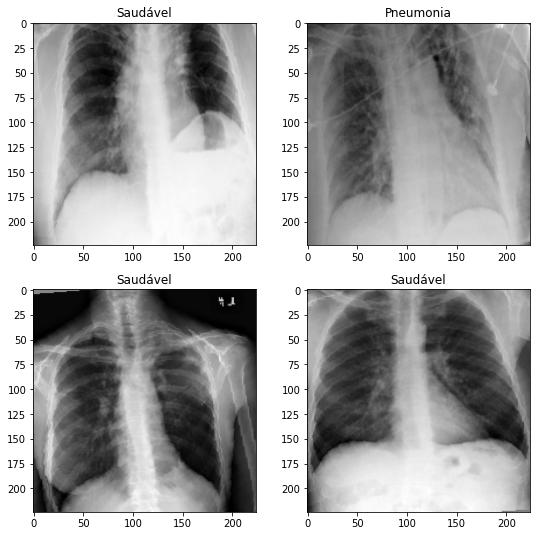

In [12]:
fig, axis = plt.subplots(2,2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 24000)
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="gray")
        if (label == 1):
            pn = "Pneumonia"
        else:
            pn = "Saudável"
        axis[i][j].set_title(pn)

batch_size = 64: Tamanho do lote, ou seja, o número de amostras que serão processadas em conjunto durante o treinamento.
num_workers = 4: Número de subprocessos que serão utilizados para carregar os dados.

Carregadores de Dados:

train_loader:

- Criado usando torch.utils.data.DataLoader.
- Utiliza o dataset de treinamento (train_dataset).
- Define o tamanho do lote (batch_size=64).
- Utiliza 4 subprocessos para carregar os dados (num_workers=4).
- Embaralha os dados (shuffle=True).

val_loader:

- Criado usando torch.utils.data.DataLoader.
- Utiliza o dataset de validação (val_dataset).
- Define o tamanho do lote (batch_size=64).
- Utiliza 4 subprocessos para carregar os dados (num_workers=4).
- Não embaralha os dados (shuffle=False).

In [13]:
batch_size = 64
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

**Visualizar train_dataset quantidade de (Pneumonia/Saudavel)  e estrutura do Resnet18**

In [14]:
np.unique(train_dataset.targets, return_counts=True)

(array([0, 1]), array([16008,  4985]))

In [ ]:
torchvision.models.resnet18() ##Visualize resnet18 structure.

**Estrutura do modelo:**

In [ ]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)#Modify first conv layer from resnet18
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)#Modify fully connected layer from resnet18
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]))
        
        ##Accuracy
        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()
        
        ##Precision
        self.train_precision = torchmetrics.Precision()
        self.val_precision = torchmetrics.Precision()
        
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        xray, label = batch
        label = label.float()
        pred = self(xray)[:,0]
        loss = self.loss_fn(pred, label)
        self.log("Train Loss", loss)
        self.log("Step Train ACC", self.train_acc(torch.sigmoid(pred), label.int()))
        self.log("Step Train Precision", self.train_precision(torch.sigmoid(pred), label.int()))
        return loss
    def training_epoch_end(self, outs):
        self.log("Train ACC", self.train_acc.compute())
        
    def validation_step(self, batch, batch_idx):
        xray, label = batch
        label = label.float()
        pred = self(xray)[:,0]
        loss = self.loss_fn(pred, label)
        
        self.log("Val Loss", loss)
        self.log("Step Val ACC", self.val_acc(torch.sigmoid(pred), label.int()))
        self.log("Step Val Precision", self.val_precision(torch.sigmoid(pred), label.int()))
    def validation_epoch_end(self, outs):
        self.log("Val ACC", self.val_acc.compute())
        
    def configure_optimizers(self):
        return [self.optimizer]
        
        

In [ ]:
model = PneumoniaModel()

Cria um checkpoint, que monitora precisão do modelo e salva o melhor.

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor="Val ACC",
    save_top_k=10,
    mode="max")

Configuraçôes adicionais do treinador

In [ ]:
gpus = 0
trainer = pl.Trainer(gpus=gpus, logger=TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1, callbacks=checkpoint_callback, max_epochs=35)

Treina o modelo.

In [ ]:
trainer.fit(model, train_loader, val_loader)

Avaliação e perfomace do Modelo:

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = PneumoniaModel.load_from_checkpoint("weights/weights_3.ckpt")
model.eval()
model.to(device)

In [ ]:
preds = []
labels = []
with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

In [ ]:
acc = torchmetrics.Accuracy()(preds, labels)
precision = torchmetrics.Precision()(preds, labels)
recall = torchmetrics.Recall()(preds, labels)
cm = torchmetrics.ConfusionMatrix(num_classes=2)(preds, labels)
print(f"Val Acurracy {acc}")
print(f"Val Precision {precision}")
print(f"Val Recall {recall}")
print(f"Confusion Matrix {cm}")

Rascunho de perguntas:

**Porque embaralhar os dados no treinamento?**

É essencial embaralhar os dados durante o treinamento, pois previne a sobreamostra de algo em especifico, por exemplo:
se as primeiros 1000 raios-x é sem pneumonia, o modelo não ira saber o que é pneumonia pois aprendeu muito com imagens sem.